# Case Study: Improving marketing effectiveness

## Introduction

> To generate more traffic and conversions, sc24 invests in paid advertising. The aim is to invest each € where it brings the most impact.
 Marketing managers would like to know whether they can improve budget allocation to marketing channels for one particular product. Moreover, they wonder if they could improve the way they currently assess the contribution of different channels.

-> How do the marketing channels currently perform? Has there been any change month over month? Estimate value of a conversion to be 100 €.
-> Can we improve the budget allocation based on last month’s performance? If yes, how should we shift the budgets? What would be the estimated effect?
-> Based on traffic data, is there another way we could consider the contribution of the different channels? If yes, show how this would be done and share your insights.


To address the marketing optimization questions, we can follow a structured approach involving data preparation, analysis, and presentation. 



## Data Preparation

### Loading the data and understanding the columns

<img src="image-20231203-191954.png" width="75%" align="" />

<img src="image-20231203-191906.png" width="75%" align="center" />

In [1]:
costs = _deepnote_execute_sql('SELECT *\nFROM \'costs_processed.csv\'', 'SQL_DEEPNOTE_DATAFRAME_SQL', audit_sql_comment='', sql_cache_mode='cache_disabled')
costs

,date,campaign_name,source_medium,impressions,clicks,spend
0,2020-04-24,de_br_reach_digitale_immobiliensuche,outbrain / display,0,0,0.00
1,2020-04-23,de_fi_generic_baufinanzierungsrechner_s_con_bu...,google / cpc,7486,1739,1941.71
2,2020-04-25,de_fi_generic_schufa_s_con_buyer_financecalc,google / cpc,361,51,174.87
3,2020-03-23,de_br_marke_+_stadt,bing / cpc,0,0,0.00
4,2020-04-05,de_br_marke,google / cpc,75928,44541,1468.00
...,...,...,...,...,...,...
2866,2020-03-27,de_br_marke_immobilien,bing / cpc,0,0,0.00
2867,2020-03-28,de_fi_kredit,bing / cpc,0,0,0.00
2868,2020-03-26,de_br_marke_bundesland,bing / cpc,0,0,0.00
2869,2020-03-21,de_fi_brand_baufinanzierung,google / cpc,0,0,0.00


In [2]:
traffic = _deepnote_execute_sql('SELECT *\nFROM \'final_traffic.csv\'', 'SQL_DEEPNOTE_DATAFRAME_SQL', audit_sql_comment='', sql_cache_mode='cache_disabled')
traffic

,date,fullvisitorID,visitStartTime,channelGrouping,medium,source,isTrueDirect,hits,bounces,timeOnSite,conversion
0,2020-03-04,1.000339e+18,1583311404,Organic Search,organic,google,True,2,NaN,446.0,0
1,2020-03-05,1.000339e+18,1583399635,Organic Search,organic,google,True,4,NaN,489.0,0
2,2020-03-06,1.000339e+18,1583504222,Organic Search,organic,google,True,4,NaN,36.0,0
3,2020-03-06,1.000339e+18,1583520755,Organic Search,organic,google,True,1,1.0,NaN,0
4,2020-03-09,1.000339e+18,1583753297,Paid Search (Non-Brand),cpc,google,False,23,NaN,257.0,1
...,...,...,...,...,...,...,...,...,...,...,...
141419,2020-04-30,8.967218e+18,1588241835,Direct,(none),(direct),False,55,NaN,2194.0,0
141420,2020-04-30,9.063905e+18,1588268232,Paid Search (Non-Brand),cpc,google,False,20,NaN,229.0,0
141421,2020-04-30,9.125349e+18,1588235466,Referral,referral,deref-gmx.net,False,42,NaN,705.0,0
141422,2020-04-30,9.203921e+17,1588223800,Paid Search (Non-Brand),cpc,google,False,35,NaN,192.0,0


In [3]:
channels = _deepnote_execute_sql(' SELECT \n    DISTINCT \n    -- source\n     channelGrouping\n    , count(*) / (SELECT count(*) FROM traffic) * 100 AS proportion\nFROM \ntraffic\nWHERE medium != \'cpc\'\nGROUP BY 1\n', 'SQL_DEEPNOTE_DATAFRAME_SQL', audit_sql_comment='', sql_cache_mode='cache_disabled')
channels

,channelGrouping,proportion
0,Organic Search,34.642635
1,Mobile App,1.006901
2,Email,29.136497
3,Direct,6.766178
4,Social Network,4.393879
5,Cooperation,3.048987
6,(Other),1.854706
7,Referral,4.451861
8,Display,1.794603
9,Push Notification,0.183844


### Merging datasets and calculating metrics

We're looking into how well our marketing channels perform over time, so we're organizing the data by date and where it's coming from. 

**Goals:**
1. Cleaning the traffic dataset:
    - Group the sources that come from "reference"
    - Clean the "group_channel" column
    - Aggregating data by "date", "source" and "channel_grouping"
    - Aggregate user or session-related information
    - Removing details related to campaigns
2. Cleaning the costs dataset:
    - Split source_medium field to match the traffic table
    - Aggregate data by "date", "source" and "medium"
    

    ----

In [4]:
funnel = _deepnote_execute_sql('WITH cs AS (\n    SELECT\n        date \n-- Split the column source_medium so it matches the traffic table \n        , SPLIT_PART(source_medium, \' / \', 1) as source\n        , SPLIT_PART(source_medium, \' / \', 2) as medium\n        , SUM(impressions) AS impressions\n        , SUM(clicks) AS clicks\n        , SUM(spend) AS spend\n    FROM costs\n    GROUP BY 1, 2,3\n)\n, tf AS (\n    SELECT\n        date\n-- The referral sources do not bring any insight separately, so they are grouped together.\n        , CASE WHEN channelGrouping = \'Referral\' THEN \'Referral\' \n               ELSE source END AS source\n        , medium\n-- Create a new channel groupping column that combines channelGrouping and medium, using the most user friendly name.\n        , CASE WHEN medium = \'cpc\' THEN \'Paid Search\'  \n               WHEN lower(channelGrouping) LIKE \'%other%\' OR\n                  channelGrouping in (select channelGrouping from channels WHERE proportion < 1.5 ) THEN \'Other\'\n               ELSE channelGrouping END AS channel_grouping\n        , SUM(hits) AS hits\n        , SUM(timeOnSite) AS time_on_site\n        , SUM(bounces) AS bounces\n        , SUM(conversion) AS conversion\n        , COUNT(fullvisitorID) AS sessions\n        , COUNT(DISTINCT fullVisitorId) AS distinct_users\n        , COUNT(DISTINCT CASE WHEN conversion = 1 THEN fullvisitorID ELSE NULL END) AS distinct_users_converted\n    FROM traffic\n    GROUP BY 1, 2,3,4\n    )   \n\nSELECT\n    date\n-- Groupping the sources that had 2 or less sessions associated to them by their channel\n    , CASE WHEN sessions < 2 THEN \'Other\' ELSE source END AS source\n    , channel_grouping\n    , medium\n    , sessions\n    , distinct_users\n    , distinct_users_converted\n    , time_on_site\n    , COALESCE(impressions, 0) AS impressions\n    , COALESCE(clicks, 0) AS clicks\n    , COALESCE(conversion, 0) AS conversion\n\n    , COALESCE(hits, 0) AS hits\n    , COALESCE(bounces, 0) AS bounces\n    , COALESCE(spend, 0) AS spend\n    , conversion * 100 AS conversion_value\nFROM tf LEFT JOIN cs USING(date, source, medium)', 'SQL_DEEPNOTE_DATAFRAME_SQL', audit_sql_comment='', sql_cache_mode='cache_disabled')
funnel

,date,source,channel_grouping,medium,sessions,distinct_users,distinct_users_converted,time_on_site,impressions,clicks,conversion,hits,bounces,spend,conversion_value
0,2020-03-09,google,Paid Search,cpc,338,245,88,199017.0,206281,119570,95,10821,13.0,7206.53,9500
1,2020-03-22,google,Paid Search,cpc,291,212,69,201250.0,148931,89510,69,10026,12.0,4376.55,6900
2,2020-04-24,google,Paid Search,cpc,206,160,75,181986.0,181233,107727,75,9083,6.0,4801.17,7500
3,2020-04-08,google,Paid Search,cpc,302,226,66,194972.0,165793,98372,70,9915,14.0,4489.34,7000
4,2020-03-31,google,Paid Search,cpc,281,208,57,172699.0,180753,107646,57,9209,9.0,4452.95,5700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2538,2020-04-29,Other,Other,(not set),1,1,0,263.0,0,0,0,34,0.0,0.00,0
2539,2020-04-29,Other,Organic Search,organic,1,1,0,414.0,0,0,0,42,0.0,0.00,0
2540,2020-04-30,Other,Cooperation,cooperation,1,1,0,157.0,0,0,0,36,0.0,0.00,0
2541,2020-04-30,Other,Organic Search,organic,1,1,0,1388.0,0,0,0,23,0.0,0.00,0


In [5]:
DeepnoteChart(funnel, """{"layer":[{"layer":[{"mark":{"clip":true,"type":"circle","color":"#4c78a8","tooltip":true},"encoding":{"x":{"sort":"ascending","type":"ordinal","field":"date","scale":{"type":"linear","zero":false},"timeUnit":"yearmonthdate"},"y":{"sort":null,"type":"quantitative","field":"impressions","scale":{"type":"linear","zero":false},"format":{"type":"default","decimals":null},"aggregate":"sum","formatType":"numberFormatFromNumberType"},"color":{"datum":"Impressions"}}}]},{"layer":[{"mark":{"clip":true,"type":"circle","color":"#e45756","tooltip":true},"encoding":{"x":{"sort":"ascending","type":"ordinal","field":"date","scale":{"type":"linear","zero":false},"timeUnit":"yearmonthdate"},"y":{"sort":null,"type":"quantitative","field":"clicks","scale":{"type":"linear","zero":false},"format":{"type":"default","decimals":null},"aggregate":"sum","formatType":"numberFormatFromNumberType"},"color":{"datum":"Clicks"}}}]},{"layer":[{"mark":{"clip":true,"type":"circle","color":"#f58518","tooltip":true},"encoding":{"x":{"axis":{"title":"Date"},"sort":"ascending","type":"ordinal","field":"date","scale":{"type":"linear","zero":false},"timeUnit":"yearmonthdate"},"y":{"axis":{"title":"Amount"},"sort":null,"type":"quantitative","field":"conversion","scale":{"type":"linear","zero":false},"format":{"type":"default","decimals":null},"aggregate":"sum","formatType":"numberFormatFromNumberType"},"color":{"datum":"Conversions "}}}]}],"title":"","config":{"legend":{"orient":"top"}},"$schema":"https://vega.github.io/schema/vega-lite/v5.json","encoding":{}}""")

In [6]:
DeepnoteChart(funnel, """{"layer":[{"layer":[{"mark":{"clip":true,"type":"circle","color":"#4c78a8","tooltip":true},"encoding":{"x":{"axis":{"title":"Date"},"sort":"ascending","type":"ordinal","field":"date","scale":{"type":"linear","zero":false},"timeUnit":"yearmonthdate"},"y":{"axis":{"title":null},"sort":null,"type":"quantitative","field":"spend","scale":{"type":"linear","zero":false},"format":{"type":"default","decimals":null},"aggregate":"sum","formatType":"numberFormatFromNumberType"},"color":{"datum":"Amount Spent"}}}]},{"layer":[{"mark":{"clip":true,"type":"circle","color":"#f58518","tooltip":true},"encoding":{"x":{"sort":"ascending","type":"ordinal","field":"date","scale":{"type":"linear","zero":false},"timeUnit":"yearmonthdate"},"y":{"sort":null,"type":"quantitative","field":"conversion_value","scale":{"type":"linear","zero":false},"format":{"type":"default","decimals":null},"aggregate":"sum","formatType":"numberFormatFromNumberType"},"color":{"datum":"Converted Value"}}}]}],"title":"","config":{"legend":{"orient":"top"}},"$schema":"https://vega.github.io/schema/vega-lite/v5.json","encoding":{}}""")

** Even when the number of impressions dropped considerably, it did not affect clicks.

## Analysis

----

### Channel performance

**Question 1** - How do the marketing channels currently perform? Has there been any change month over month? 

**Goals:**
1. Analyse marketing channel performance 
    - Revenue and Costs distribution by "Channel Grouping"
    - Proportion that each "Channel Grouping" represents
2. Analyse paid channel performance
    - Calculate the return on Ad Spend for each paid channel
    - Analyse if there is a variation in investiment/return during the analysed period
3. Analyse MOM changes
    - Compare the "revenue", "spend" and "conversion" values for each month

<br>


In [7]:
revenue_by_channel = _deepnote_execute_sql('SELECT\n    source\n    , channel_grouping\n    , SUM(spend) AS total_cost\n    , SUM(conversion) * 100 AS converted_revenue    \n    , SUM(impressions) AS total_impressions\n    , SUM(sessions) AS total_sessions\n    , SUM(clicks) AS total_clicks\n    , SUM(clicks) / SUM(impressions) * 100 AS click_through_rate\n    , SUM(conversion) AS total_conversions\n    , SUM(hits) AS total_hits\n    , SUM(bounces) AS total_bounces\n    , SUM(time_on_site) AS total_time_on_site\nFROM funnel\nGROUP BY 1,2', 'SQL_DEEPNOTE_DATAFRAME_SQL', audit_sql_comment='', sql_cache_mode='cache_disabled')
revenue_by_channel

,source,channel_grouping,total_cost,converted_revenue,total_impressions,total_sessions,total_clicks,click_through_rate,total_conversions,total_hits,total_bounces,total_time_on_site
0,google,Paid Search,323478.170000,486400,10875939,17226,6458585,59.384160,4864,594078,740.0,11488739.0
1,bing,Paid Search,36250.900000,16600,826977,737,268208,32.432341,166,23802,33.0,534807.0
2,outbrain,Display,0.000000,1700,0,453,0,NaN,17,10740,83.0,162488.0
3,facebook,Display,24979.030002,72300,5440545,878,39644,0.728677,723,15813,42.0,323526.0
4,Other,Paid Search,0.000000,300,0,7,0,NaN,3,209,0.0,3779.0
...,...,...,...,...,...,...,...,...,...,...,...,...
73,immobilienscout24,Display,0.000000,0,0,24,0,NaN,0,896,0.0,29825.0
74,kleinanzeige.focus.de,Other,0.000000,0,0,2,0,NaN,0,283,0.0,10770.0
75,podcast,Social Network,0.000000,0,0,3,0,NaN,0,132,0.0,2014.0
76,int.search.tb.ask.com,Organic Search,0.000000,0,0,6,0,NaN,0,40,0.0,969.0


In [8]:
DeepnoteChart(revenue_by_channel, """{"layer":[{"layer":[{"mark":{"clip":true,"type":"bar","color":"#4c78a8","tooltip":true},"encoding":{"x":{"axis":{"grid":false,"title":"Value "},"sort":null,"type":"quantitative","field":"converted_revenue","scale":{"type":"linear"},"format":{"type":"default","decimals":null},"aggregate":"sum","formatType":"numberFormatFromNumberType"},"y":{"axis":{"grid":false},"sort":null,"type":"nominal","field":"channel_grouping","scale":{"type":"linear"}},"color":{"datum":"Converted revenue"},"yOffset":{"datum":"Converted revenue"}}}]},{"layer":[{"mark":{"clip":true,"type":"bar","color":"#f58518","tooltip":true},"encoding":{"x":{"axis":{"grid":false},"sort":null,"type":"quantitative","field":"total_cost","scale":{"type":"linear"},"format":{"type":"default","decimals":null},"aggregate":"sum","formatType":"numberFormatFromNumberType"},"y":{"axis":{"grid":false},"sort":null,"type":"nominal","field":"channel_grouping","scale":{"type":"linear"}},"color":{"datum":"Cost"},"yOffset":{"datum":"Cost"}}}]}],"title":"","config":{"legend":{"orient":"top"}},"$schema":"https://vega.github.io/schema/vega-lite/v5.json","encoding":{}}""")

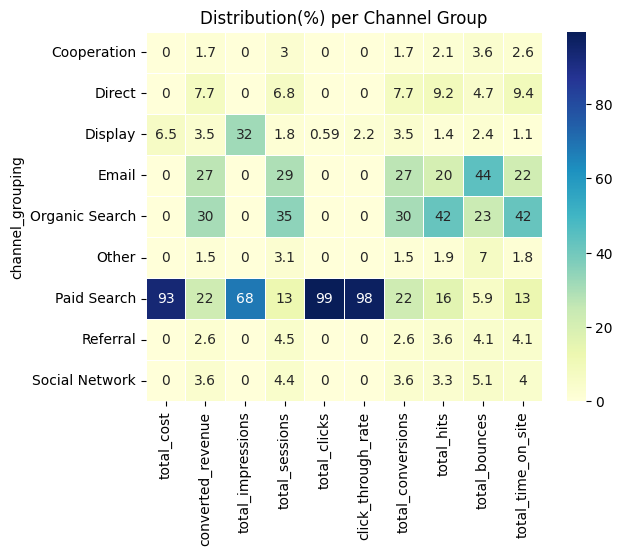

In [9]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt # for data visualization

df = revenue_by_channel.groupby('channel_grouping').sum().reset_index()
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
df[numeric_cols] = df[numeric_cols].div(df[numeric_cols].sum(axis=0), axis=1) * 100
df.set_index('channel_grouping', inplace=True)
sns.heatmap(df, annot=True, linewidth=.5, cmap="YlGnBu")
plt.title('Distribution(%) per Channel Group')
plt.show()

<br>

> Upon analyzing the revenue distribution across different channels, a distinct pattern emerges – a **significant proportion of conversions originates from non-paid searches.** 
>
> Organic search for example, is 30% of the revenue and 35% of all the sessions, with the highest time on site, showing that the revenue can also be reached by investing in aspects other than Paid Ad, such as campaigns, user interface improvements, etc. 
>
> This observation also signifies a notable level of trust by the customer in sc24. Importantly, the strategic advantage lies in the lack of direct advertising costs associated with these organic conversions. Individuals who arrive via non-paid searches typically have a specific purpose or intent. They actively seek information related to products, services, or specific topics, indicating an increased likelihood of conversion. 
>
>This user segment is often in the consideration or decision stage of the purchasing journey, rendering their engagement particularly valuable.

----

### Return on Ad Spend

In [10]:
df_12 = _deepnote_execute_sql('select * \nfrom costs \nwhere source_medium LIKE \'%Paid Search%\'', 'SQL_DEEPNOTE_DATAFRAME_SQL', audit_sql_comment='', sql_cache_mode='cache_disabled')
df_12

,date,campaign_name,source_medium,impressions,clicks,spend


In [11]:
roas = _deepnote_execute_sql('SELECT \n    date::date AS date\n    , source\n    , SUM(conversion_value) AS conversion_value\n    , SUM(spend) AS spend\n    ,(SUM(conversion_value)/SUM(spend))::DECIMAL(10,2) AS return_on_ad_spend\n    , SUM(impressions) AS impressions\n    , SUM(clicks) AS clicks\n    , SUM(conversion) AS conversions\nFROM funnel\nWHERE (channel_grouping = (\'Paid Search\') \n    OR (source = (\'facebook\') AND channel_grouping = (\'Display\')))\n    AND source != \'Other\'\nGROUP BY 1,2', 'SQL_DEEPNOTE_DATAFRAME_SQL', audit_sql_comment='', sql_cache_mode='cache_disabled')
roas

,date,source,conversion_value,spend,return_on_ad_spend,impressions,clicks,conversions
0,2020-03-09,google,9500,7206.53,1.32,206281,119570,95
1,2020-03-22,google,6900,4376.55,1.58,148931,89510,69
2,2020-04-24,google,7500,4801.17,1.56,181233,107727,75
3,2020-04-08,google,7000,4489.34,1.56,165793,98372,70
4,2020-03-31,google,5700,4452.95,1.28,180753,107646,57
...,...,...,...,...,...,...,...,...
167,2020-04-11,facebook,800,269.69,2.97,23926,330,8
168,2020-04-03,facebook,800,266.16,3.01,27267,383,8
169,2020-04-14,facebook,1300,301.72,4.31,30851,426,13
170,2020-03-08,facebook,3100,883.57,3.51,165594,1452,31


In [12]:
period_roas = _deepnote_execute_sql('SELECT \n    date_trunc(\'month\', date) AS date\n    , source\n    , (SUM(conversion_value)/SUM(spend))::DECIMAL(10,2) AS roas\n    , SUM(spend) AS spend\n    , SUM(conversion_value) AS converted\nFROM roas\nGROUP BY 1,2', 'SQL_DEEPNOTE_DATAFRAME_SQL', audit_sql_comment='', sql_cache_mode='cache_disabled')
period_roas

,date,source,roas,spend,converted
0,2020-03-01,google,1.35,162601.330000,220300
1,2020-04-01,google,1.65,160876.840000,266100
2,2020-03-01,bing,0.45,33913.600000,15200
3,2020-04-01,bing,0.60,2337.300000,1400
4,2020-03-01,facebook,2.63,17387.230002,45800
5,2020-04-01,facebook,3.49,7591.800000,26500


The Return on Advertising Spend (ROAS) for each of the paid source media for the giving period is as follows:
1. Google:        March = 1.35 -> April = 1.65
2. Facebook:    March = 2.63 -> April = 3.49
3. Bing:             March = 0.45 -> April = 0.6

In general, the investment is bringing more return in April than in March, and Facebook's strategy provides the highest return on ad spend, closely followed by Google's strategy. Bing's strategy returns less than half of the investment, indicating a possible need for strategy adjustment or reallocation of resources, which will be investigated deeper in the following sections.

In [13]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=len(roas['source'].unique()), subplot_titles=roas['source'].unique())

for idx, source in enumerate(roas['source'].unique()):
    current_source_data = roas[roas['source'] == source][['conversion_value', 'spend', 'date']].sort_values('date')

    fig.add_trace(go.Bar(x=current_source_data['date'], y=current_source_data['conversion_value'], name='return', marker=dict(color='skyblue')), row=idx+1, col=1)
    fig.add_trace(go.Scatter(x=current_source_data['date'], y=current_source_data['spend'], name='invested', line=dict(color='darksalmon')), row=idx+1, col=1)

fig.update_layout(height=700, width=900, showlegend=False)
fig.show()

The daily analysis consistently shows positive returns from Google and Facebook channels, affirming their effectiveness in generating revenue. However, the ROAS data highlights a less favorable performance from Bing, prompting a budget adjustment. Notably, there's a substantial decrease in investments in Bing starting from April, indicating a proactive response to lower returns. This strategic shift aims to align the budget with more effective channels, optimizing resource allocation for improved overall performance.

Additionally, there's a notable reduction in spending on Facebook, possibly reflecting an adjustment to the ROAS. This shift is observed from March (2.63) to April (3.49), suggesting a strategic move to adapt and enhance overall performance.

---

### Budget allocation

**Question 2** - Can we improve the budget allocation based on last month’s performance? If yes, how should we shift the budgets? What would be the estimated effect?

**Goals:**
- Analyse the budget of each month and its allocation
- Allocation x ROA
- Simulate an ideal allocation, with each source in their optimal point 


In [14]:
df_roas = _deepnote_execute_sql('WITH base AS (\n    SELECT DISTINCT\n        date_trunc(\'month\', date) AS month\n        , source\n        , SUM(spend)::INT AS source_budget\n        , SUM(conversion_value)::INT AS source_revenue\n        , (SUM(conversion_value)/SUM(spend))::DECIMAL(10,2) AS roas\n    FROM roas \n    GROUP BY 1,2\n    ORDER BY source, month\n)\n\n, totals AS (\n    SELECT \n        month\n        , SUM(source_budget) AS total_budget\n        , SUM(source_revenue)  AS total_revenue\n        , SUM(roas)::DECIMAL(10,2) AS total_roas\n    FROM base\n    GROUP BY 1\n)\n\nSELECT \n    source\n    , roas\n    , source_budget\n    , source_revenue\n    , (total_budget * (roas / total_roas))::int AS proposed_budget\n    , proposed_budget - source_budget AS budget_difference\n    , (proposed_budget * roas)::INT AS new_revenue\n    , (new_revenue - source_revenue)::INT AS estimated_effect\n    , total_budget\n    , total_revenue\n    , total_roas\n\nfrom base JOIN totals USING(month)\nWHERE month = (SELECT MAX(month) FROM totals)', 'SQL_DEEPNOTE_DATAFRAME_SQL', audit_sql_comment='', sql_cache_mode='cache_disabled')
df_roas

,source,roas,source_budget,source_revenue,proposed_budget,budget_difference,new_revenue,estimated_effect,total_budget,total_revenue,total_roas
0,bing,0.60,2337,1400,17854,15517,10712,9312,170806,294000,5.74
1,facebook,3.49,7592,26500,103852,96260,362443,335943,170806,294000,5.74
2,google,1.65,160877,266100,49099,-111778,81013,-185087,170806,294000,5.74


In [15]:
df_13 = _deepnote_execute_sql('SELECT source\n    , (roas/total_roas)::DECIMAL(10,2) AS proportion_ROAS\n    \n    , (source_budget/total_budget * 100)::DECIMAL(10,2) AS proportion_budget\n    , (proposed_budget/total_budget * 100)::DECIMAL(10,2) AS new_proportion_budget\n\n    , (source_revenue/total_revenue *100)::DECIMAL(10,2) AS proportion_revenue\n    , (new_revenue/(select sum(new_revenue) from df_roas) *100)::DECIMAL(10,2) AS new_proportion_revenue\n\n\n\nFROM df_roas', 'SQL_DEEPNOTE_DATAFRAME_SQL', audit_sql_comment='', sql_cache_mode='cache_disabled')
df_13

,source,proportion_ROAS,proportion_budget,new_proportion_budget,proportion_revenue,new_proportion_revenue
0,bing,0.10,1.37,10.45,0.48,2.36
1,facebook,0.61,4.44,60.80,9.01,79.80
2,google,0.29,94.19,28.75,90.51,17.84


In [16]:
DeepnoteChart(df_13, """{"layer":[{"layer":[{"mark":{"clip":true,"type":"bar","color":"#4c78a8","tooltip":true},"encoding":{"x":{"axis":{"grid":false,"title":"% of the Budget"},"sort":null,"type":"quantitative","field":"proportion_budget","scale":{"type":"linear"},"format":{"type":"default","decimals":null},"aggregate":"sum","formatType":"numberFormatFromNumberType"},"y":{"axis":{"grid":false},"sort":null,"type":"nominal","field":"source","scale":{"type":"linear"}},"color":{"datum":"Original budget proportion"},"yOffset":{"datum":"Original budget proportion"}}},{"mark":{"dx":3,"dy":0,"fill":"black","type":"text","align":"left","baseline":"middle"},"encoding":{"x":{"axis":{"grid":false,"title":"% of the Budget"},"sort":null,"type":"quantitative","field":"proportion_budget","scale":{"type":"linear"},"format":{"type":"default","decimals":null},"aggregate":"sum","formatType":"numberFormatFromNumberType"},"y":{"axis":{"grid":false},"sort":null,"type":"nominal","field":"source","scale":{"type":"linear"}},"text":{"sort":null,"type":"quantitative","field":"proportion_budget","aggregate":"sum"},"color":{"datum":"Original budget proportion"},"yOffset":{"datum":"Original budget proportion"}}}]},{"layer":[{"mark":{"clip":true,"type":"bar","color":"#f58518","tooltip":true},"encoding":{"x":{"axis":{"grid":false},"sort":null,"type":"quantitative","field":"new_proportion_budget","scale":{"type":"linear"},"format":{"type":"default","decimals":null},"aggregate":"sum","formatType":"numberFormatFromNumberType"},"y":{"axis":{"grid":false},"sort":null,"type":"nominal","field":"source","scale":{"type":"linear"}},"color":{"datum":"New proportion"},"yOffset":{"datum":"New proportion"}}},{"mark":{"dx":3,"dy":0,"fill":"black","type":"text","align":"left","baseline":"middle"},"encoding":{"x":{"axis":{"grid":false},"sort":null,"type":"quantitative","field":"new_proportion_budget","scale":{"type":"linear"},"format":{"type":"default","decimals":null},"aggregate":"sum","formatType":"numberFormatFromNumberType"},"y":{"axis":{"grid":false},"sort":null,"type":"nominal","field":"source","scale":{"type":"linear"}},"text":{"sort":null,"type":"quantitative","field":"new_proportion_budget","aggregate":"sum"},"color":{"datum":"New proportion"},"yOffset":{"datum":"New proportion"}}}]}],"title":"Budget","config":{"legend":{"orient":"top"}},"$schema":"https://vega.github.io/schema/vega-lite/v5.json","encoding":{}}""")

In [17]:
DeepnoteChart(df_13, """{"layer":[{"layer":[{"mark":{"clip":true,"type":"bar","color":"#f58518","tooltip":true},"encoding":{"x":{"axis":{"grid":false,"title":"% of the Budget"},"sort":null,"type":"quantitative","field":"proportion_revenue","scale":{"type":"linear"},"format":{"type":"default","decimals":null},"aggregate":"sum","formatType":"numberFormatFromNumberType"},"y":{"axis":{"grid":false},"sort":null,"type":"nominal","field":"source","scale":{"type":"linear"}},"color":{"datum":"Original revenue proportion"},"yOffset":{"datum":"Original revenue proportion"}}},{"mark":{"dx":3,"dy":0,"fill":"black","type":"text","align":"left","baseline":"middle"},"encoding":{"x":{"axis":{"grid":false,"title":"% of the Budget"},"sort":null,"type":"quantitative","field":"proportion_revenue","scale":{"type":"linear"},"format":{"type":"default","decimals":null},"aggregate":"sum","formatType":"numberFormatFromNumberType"},"y":{"axis":{"grid":false},"sort":null,"type":"nominal","field":"source","scale":{"type":"linear"}},"text":{"sort":null,"type":"quantitative","field":"proportion_revenue","aggregate":"sum"},"color":{"datum":"Original revenue proportion"},"yOffset":{"datum":"Original revenue proportion"}}}]},{"layer":[{"mark":{"clip":true,"type":"bar","color":"#4c78a8","tooltip":true},"encoding":{"x":{"axis":{"grid":false},"sort":null,"type":"quantitative","field":"new_proportion_revenue","scale":{"type":"linear"},"format":{"type":"default","decimals":null},"aggregate":"sum","formatType":"numberFormatFromNumberType"},"y":{"axis":{"grid":false},"sort":null,"type":"nominal","field":"source","scale":{"type":"linear"}},"color":{"datum":"New proportion"},"yOffset":{"datum":"New proportion"}}},{"mark":{"dx":3,"dy":0,"fill":"black","type":"text","align":"left","baseline":"middle"},"encoding":{"x":{"axis":{"grid":false},"sort":null,"type":"quantitative","field":"new_proportion_revenue","scale":{"type":"linear"},"format":{"type":"default","decimals":null},"aggregate":"sum","formatType":"numberFormatFromNumberType"},"y":{"axis":{"grid":false},"sort":null,"type":"nominal","field":"source","scale":{"type":"linear"}},"text":{"sort":null,"type":"quantitative","field":"new_proportion_revenue","aggregate":"sum"},"color":{"datum":"New proportion"},"yOffset":{"datum":"New proportion"}}}]}],"title":"Revenue","config":{"legend":{"orient":"top"}},"$schema":"https://vega.github.io/schema/vega-lite/v5.json","encoding":{}}""")

The proposed budget allocation based on the last month's ROAS performance suggests the following changes:

1. Bing 
> current budget: 2.337
> proposed budget: 21.564
> difference: + 19.227
>
> current revenue: 1.700
> estimated revenue: 15.742
> estimated effect: 14.035

2. Facebook  
> current budget: 7.592
> proposed budget: 103.852
> difference: + 96.260
>
> current revenue: 9.6260
> estimated revenue: 96.260
> estimated effect: 335.943

3. Google
> current budget: 160.877
> proposed budget: 49.099
> difference: -111.778
>
> current revenue: 266.100
> estimated revenue: 81.013
> estimated effect: -185.087

- Total revenue increase: 160.168


Note that this assumes that the increase or decrease in spending will result in proportional changes in conversion value. However, in reality, factors such as market saturation, diminishing returns, and changes in consumer behavior may affect the actual results. 

The proposed shifts in budget allocation aim to optimize the return on ad spend by investing more in channels with high ROAS (Facebook and Bing in this case) and less in channels with lower ROAS (Google in this case). It is important to continuously monitor the performance of these channels to ensure the effectiveness of these changes. The market and consumer behavior are dynamic and as such, the optimal budget allocation may change over time.

---

In [18]:
df_10 = _deepnote_execute_sql('WITH base as (\nSELECT \n    source\n    , source_budget\n    , CASE WHEN source = \'bing\' THEN source_budget - 5000\n     WHEN source = \'facebook\' THEN source_budget + 3000\n     WHEN source = \'google\' THEN source_budget + 2000 END AS simulated_budget\n    , roas * simulated_budget AS simulated_revenue\n    , source_revenue\n    , new_revenue\n    , simulated_revenue - source_revenue AS simulated_effect\n    , estimated_effect\n    , simulated_effect - estimated_effect AS simulaion_difference\nfrom df_roas \n)\nSELECT \n    SUM(source_budget) AS source_budget\n    , SUM(source_revenue) AS source_revenue\n\n    , SUM(simulated_budget) AS simulated_budget\n\n    , SUM(simulated_revenue) AS simulated_revenue\n    , SUM(new_revenue) AS proposed_revenue\n\n    , SUM(simulated_revenue) - SUM(source_revenue) AS simulated_effect\n    , SUM(new_revenue) - SUM(source_revenue) AS proposed_effect\nFROM base', 'SQL_DEEPNOTE_DATAFRAME_SQL', audit_sql_comment='', sql_cache_mode='cache_disabled')
df_10

,source_budget,source_revenue,simulated_budget,simulated_revenue,proposed_revenue,simulated_effect,proposed_effect
0,170806,294000,170806,304115.33,454168,10115.33,160168


In [19]:
df_8 = _deepnote_execute_sql('SELECT\n     SUM(source_budget) AS original_budget\n    , SUM(source_revenue) AS original_revenue\n\n    , SUM(proposed_budget) AS proposed_budget\n    , SUM(new_revenue) AS simulated_revenue\nFROM df_roas', 'SQL_DEEPNOTE_DATAFRAME_SQL', audit_sql_comment='', sql_cache_mode='cache_disabled')
df_8

,original_budget,original_revenue,proposed_budget,simulated_revenue
0,170806,294000,170805,454168


### Alternative Metrics

**Question 3** - Based on traffic data, is there another way we could consider the contribution of the different channels? If yes, show how this would be done and share your insights.

**Goals:**
- Examine additional metrics apart from the simple conversion value or count. 

- Conversion rate: Number of conversions divided by the total number of visitors (conversions/visitors). It gives an idea of how successful the channel is in driving conversions relative to the number of users it attracts.
- Bounce rate: Number of visitors who leave the site after viewing just one page (bounces/visits). A high bounce rate might indicate that users brought in by the channel are not finding what they expect or need on the site.
 - Time on site: Estimate of user engagement. If users from a certain channel spend more time on the site, they could be more interested in the content or offerings, and possibly more likely to convert.
- Impression per user / Clicks per user:  These metrics can tell us, on average, how many ads a user from each source saw (impressions per user) and how many of them they clicked on (clicks per user). This can help us evaluate the user engagement for each,

In [20]:
additional_metrics = _deepnote_execute_sql('SELECT\n    source\n    , sum(conversion)/sum(sessions) AS conversion_rate\n    , sum(bounces)/sum(sessions) AS bounce_rate\n    , sum(time_on_site)/sum(sessions) AS time_on_site\n    , avg(impressions)/sum(sessions) impressions_per_user\n    , avg(clicks)/sum(sessions) AS clicks_per_user\n    , sum(sessions) AS total_users\n    , sum(distinct_users) AS distinct_users\n    , sum(conversion) AS conversions\n    , sum(bounces) AS bounces\nFROM funnel\nGROUP BY 1\nHAVING sum(conversion) > 0\n', 'SQL_DEEPNOTE_DATAFRAME_SQL', audit_sql_comment='', sql_cache_mode='cache_disabled')
additional_metrics

,source,conversion_rate,bounce_rate,time_on_site,impressions_per_user,clicks_per_user,total_users,distinct_users,conversions,bounces
0,google,0.176064,0.058100,740.664094,1.404023,0.833767,63494,42203,11179,3689.0
1,bing,0.193033,0.043179,960.965893,2.679145,0.868909,2756,2006,532,119.0
2,outbrain,0.037528,0.183223,358.693157,0.000000,0.000000,453,417,17,83.0
3,facebook,0.732535,0.053892,407.165669,61.007704,0.444549,1002,906,734,54.0
4,Other,0.183673,0.181406,659.707483,0.116546,0.001507,441,441,81,80.0
5,android,0.088032,0.236400,254.655786,0.000000,0.000000,1011,741,89,239.0
6,sfmc,0.094627,0.169478,478.244117,0.000000,0.000000,14108,8847,1335,2391.0
7,system,0.174532,0.127151,482.531740,0.000000,0.000000,26150,15221,4564,3325.0
8,(direct),0.180374,0.064166,892.133661,0.000000,0.000000,9569,6659,1726,614.0
9,regular,0.100909,0.137273,564.441818,0.000000,0.000000,1100,786,111,151.0


The calculated data shows the average number of impressions and clicks per user for different sources. A higher 'impressions_per_user' number means that a user from that source tends to see more ads, while a higher 'clicks_per_user' number means a user from that source tends to click on more ads. However, it appears that for many sources the average impressions and clicks per user are quite low, possibly due to a high number of users but low ad exposure or engagement.
While we have focused on traffic data for this analysis and in answering the previous questions, we could extend this technique to different aspects of the business such as customer segmentation, product performance, and regional performance, among others. This will provide a more comprehensive picture of the business's performance and allow for more effective decision-making.

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate correlations
corr = additional_metrics.corr()
corr.conversion_rate.sort_values(ascending=False)

conversion_rate         1.000000
impressions_per_user    0.719793
clicks_per_user         0.338961
time_on_site            0.161119
conversions             0.116087
distinct_users          0.071005
total_users             0.067032
bounces                 0.039982
bounce_rate            -0.167953
Name: conversion_rate, dtype: float64

> From the Correlation Matrix, we can derive the following insights:

1. 'Conversion Rate' is strongly positively correlated with 'Time on Site'. This implies that users spending more time on the site are more likely to convert. This makes intuitive sense as users who spend more time on the site are likely more engaged and thus more likely to make a purchase or complete a desired action.

2. 'Impressions Per User' has a moderate positive correlation with 'Conversion Rate'. This implies that as the user views more ads, they tend to click on ads more often.

3. 'Bounce Rate' has a strong negative correlation with 'Time on Site'. This means that the longer users stay on the site, the less likely they are to bounce

This correlation matrix provides insights into the relationships between different metrics, which can help in understanding user behavior and creating effective marketing strategies. For example, strategies can be made to increase user engagement and time spent on the site to increase conversions, or efforts can be made to reduce bounce rates, which can also potentially lead to higher conversions.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=2254e57f-f4d0-4158-b195-020957cbda5d' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>